# NLP with oil and renewable energies project

#### Get libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sqlalchemy import create_engine
import numpy as np
from sklearn import metrics

## Creating month weights

In [2]:
corpus_oil_price=pd.read_csv("data/corpus_oil_price.csv", index_col=0)
corpus_alternative_energies=pd.read_csv("data/corpus_alternative_energies.csv", index_col=0)
corpus_crude_oil=pd.read_csv("data/corpus_crude_oil.csv", index_col=0)

In [3]:
corpus_oil_price["date_published"] = pd.to_datetime(corpus_oil_price["date_published"], utc=True)
corpus_alternative_energies["date_published"] = pd.to_datetime(corpus_alternative_energies["date_published"], utc=True)
corpus_crude_oil["date_published"] = pd.to_datetime(corpus_crude_oil["date_published"], utc=True)
corpus_crude_oil


,title,date_published,content,baseline_sentiment,vader_sentiment
0,Oil Bulls Rejoice As Biden's Supply Strategy B...,2021-11-25 00:00:00+00:00,President Biden&rsquo;s threat to oil producer...,-1,-0.9926
1,"OPEC To Add 400,000 Bpd In January Despite Oil...",2021-12-02 14:53:55+00:00,The OPEC group is sticking to its plan to ease...,0,0.4497
2,UAE Pumps $6 Billion Into Oil And Gas Expansio...,2021-11-24 23:00:00+00:00,The U.S.-sponsored &lsquo;relationship normali...,1,0.9875
3,China Keeps Markets In The Dark About SPR Release,2021-11-24 22:00:00+00:00,The volume of the expected Chinese release of ...,-1,-0.9552
4,Oil Markets Unimpressed By Small Crude Invento...,2021-11-24 15:36:00+00:00,"Crude oil inventories rose last week, while ga...",-1,-0.9601
...,...,...,...,...,...
5000,A Detailed Guide on the Many Different Types o...,2009-12-02 23:12:01+00:00,Some people arbitrarily speak about oil as if ...,-1,-0.9962
5001,What is Peak Oil Theory A Thorough Look at Thi...,2009-10-21 21:17:44+00:00,Currently there is a lot of debate going on re...,1,-0.1567
5002,Oil Shale - So Just What Is It,2009-09-24 22:26:55+00:00,People often say &ldquo;You can&rsquo;t squeez...,-1,0.9816
5003,Oil is not a Villain Here's what it's done for us,2009-09-21 21:45:02+00:00,"For decades now, oil has often been vilified a...",1,0.9987


In [4]:
corpus_oil_price["month"] = corpus_oil_price["date_published"].dt.month
corpus_alternative_energies["month"] = corpus_alternative_energies["date_published"].dt.month
corpus_oil_price

,title,date_published,content,baseline_sentiment,vader_sentiment,month
0,$70 Oil Won't Keep OPEC Happy,2021-11-30 01:00:00+00:00,One day&mdash;that was all it took oil prices ...,-1,0.9448,11
1,Why This Oil Price Slump May Not Be Bad News F...,2021-12-03 01:00:00+00:00,Crude oil prices are plunging under the weight...,-1,0.9957,12
2,The Double Irony Of Biden's Plea To OPEC,2021-11-10 19:00:00+00:00,As I wrote in February of this year in&nbsp;Th...,-1,0.8805,11
3,The Oil Price Rally Is Far From Over,2021-11-10 01:00:00+00:00,How much higher could oil prices go This is th...,1,0.1027,11
4,"Biden Threatens OPEC With Undisclosed ""Tools""",2021-11-08 16:00:00+00:00,"""There are other tools in the arsenal that we ...",-1,-0.6269,11
...,...,...,...,...,...,...
2183,A Disobliging Update on the Price of Oil,2010-01-09 22:21:21+00:00,There still seems to be a deplorable uncertain...,-1,0.9947,1
2184,What Happens When the Wells Run Dry,2010-01-08 22:55:39+00:00,One nagging question that the industrial world...,1,-0.7541,1
2185,Petro Unfriendly California Changing it's Stan...,2009-12-30 20:18:05+00:00,The financial crisis changed the way people th...,-1,0.0982,12
2186,New Techniques Oil Companies are Using in Dril...,2009-11-25 22:35:34+00:00,As the politics and philosophical arguments ab...,1,0.9985,11


In [5]:
corpus_oil_price_resampled = corpus_oil_price.resample('M', on='date_published').mean()
corpus_alternative_energies_resampled = corpus_alternative_energies.resample('M', on='date_published').mean()
corpus_crude_oil_resampled = corpus_crude_oil.resample('M', on='date_published').mean()

In [6]:
corpus_oil_price_resampled.index = pd.to_datetime(corpus_oil_price_resampled.index).strftime('%Y-%m')
corpus_alternative_energies_resampled.index = pd.to_datetime(corpus_alternative_energies_resampled.index).strftime('%Y-%m')
corpus_crude_oil_resampled.index = pd.to_datetime(corpus_crude_oil_resampled.index).strftime('%Y-%m')
corpus_oil_price_resampled

,baseline_sentiment,vader_sentiment,month
date_published,,,
2009-11,1.000000,0.998550,11.0
2009-12,-1.000000,0.098200,12.0
2010-01,0.000000,0.128680,1.0
2010-02,0.000000,0.567283,2.0
2010-03,0.111111,0.848289,3.0
...,...,...,...
2021-08,-0.560000,-0.545292,8.0
2021-09,-0.250000,-0.237639,9.0
2021-10,-0.476190,-0.447929,10.0


In [7]:
y = pd.get_dummies(corpus_oil_price_resampled.month, prefix='month')
corpus_oil_price_resampled2 = corpus_oil_price_resampled.merge(y, on="date_published")
corpus_oil_price_resampled2

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
date_published,,,,,,,,,,,,,,,
2009-11,1.000000,0.998550,11.0,0,0,0,0,0,0,0,0,0,0,1,0
2009-12,-1.000000,0.098200,12.0,0,0,0,0,0,0,0,0,0,0,0,1
2010-01,0.000000,0.128680,1.0,1,0,0,0,0,0,0,0,0,0,0,0
2010-02,0.000000,0.567283,2.0,0,1,0,0,0,0,0,0,0,0,0,0
2010-03,0.111111,0.848289,3.0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,-0.560000,-0.545292,8.0,0,0,0,0,0,0,0,1,0,0,0,0
2021-09,-0.250000,-0.237639,9.0,0,0,0,0,0,0,0,0,1,0,0,0
2021-10,-0.476190,-0.447929,10.0,0,0,0,0,0,0,0,0,0,1,0,0


In [8]:
z = pd.get_dummies(corpus_alternative_energies_resampled.month, prefix='month')
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled.merge(z, on="date_published")
corpus_alternative_energies_resampled2

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
date_published,,,,,,,,,,,,,,,
2009-07,1.000000,0.931183,7.0,0,0,0,0,0,0,1,0,0,0,0,0
2009-08,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2009-09,1.000000,0.998050,9.0,0,0,0,0,0,0,0,0,1,0,0,0
2009-10,1.000000,0.978400,10.0,0,0,0,0,0,0,0,0,0,1,0,0
2009-11,1.000000,0.996250,11.0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07,0.666667,0.809125,7.0,0,0,0,0,0,0,1,0,0,0,0,0
2021-08,0.692308,0.704685,8.0,0,0,0,0,0,0,0,1,0,0,0,0
2021-09,0.714286,0.753671,9.0,0,0,0,0,0,0,0,0,1,0,0,0


### Regression with oil prices

In [9]:
corpus_oil_price_resampled2.isna().sum()

baseline_sentiment    4
vader_sentiment       4
month                 4
month_1.0             0
month_2.0             0
month_3.0             0
month_4.0             0
month_5.0             0
month_6.0             0
month_7.0             0
month_8.0             0
month_9.0             0
month_10.0            0
month_11.0            0
month_12.0            0
dtype: int64

In [10]:
is_NaN = corpus_oil_price_resampled2.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = corpus_oil_price_resampled2[row_has_NaN]
rows_with_NaN

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
date_published,,,,,,,,,,,,,,,
2012-11,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2013-05,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2013-07,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2014-01,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
corpus_oil_price_resampled2.index = pd.to_datetime(corpus_oil_price_resampled2.index)
corpus_oil_price_resampled2['vader_sentiment'].interpolate(method='polynomial', order=2, inplace=True)

In [12]:
is_NaN = corpus_oil_price_resampled2.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = corpus_oil_price_resampled2[row_has_NaN]
rows_with_NaN

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
date_published,,,,,,,,,,,,,,,
2012-11-01,NaN,-0.399684,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,NaN,0.977149,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2013-07-01,NaN,0.123677,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-01,NaN,0.422792,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
corpus_oil_price_resampled2.to_csv('data/corpus_oil_price_resampled2.csv')
corpus_oil_price_resampled2

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
date_published,,,,,,,,,,,,,,,
2009-11-01,1.000000,0.998550,11.0,0,0,0,0,0,0,0,0,0,0,1,0
2009-12-01,-1.000000,0.098200,12.0,0,0,0,0,0,0,0,0,0,0,0,1
2010-01-01,0.000000,0.128680,1.0,1,0,0,0,0,0,0,0,0,0,0,0
2010-02-01,0.000000,0.567283,2.0,0,1,0,0,0,0,0,0,0,0,0,0
2010-03-01,0.111111,0.848289,3.0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,-0.560000,-0.545292,8.0,0,0,0,0,0,0,0,1,0,0,0,0
2021-09-01,-0.250000,-0.237639,9.0,0,0,0,0,0,0,0,0,1,0,0,0
2021-10-01,-0.476190,-0.447929,10.0,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
corpus_oil_price_resampled2=pd.read_csv("data/corpus_oil_price_resampled2.csv", index_col=0)
corpus_oil_price_resampled2

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
date_published,,,,,,,,,,,,,,,
2009-11-01,1.000000,0.998550,11.0,0,0,0,0,0,0,0,0,0,0,1,0
2009-12-01,-1.000000,0.098200,12.0,0,0,0,0,0,0,0,0,0,0,0,1
2010-01-01,0.000000,0.128680,1.0,1,0,0,0,0,0,0,0,0,0,0,0
2010-02-01,0.000000,0.567283,2.0,0,1,0,0,0,0,0,0,0,0,0,0
2010-03-01,0.111111,0.848289,3.0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,-0.560000,-0.545292,8.0,0,0,0,0,0,0,0,1,0,0,0,0
2021-09-01,-0.250000,-0.237639,9.0,0,0,0,0,0,0,0,0,1,0,0,0
2021-10-01,-0.476190,-0.447929,10.0,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:
oil_price=pd.read_csv("data/oil_prices.csv", index_col=0)
oil_price

,Brent,oil_production,oil_consumption,interaction_term,date,interaction_term_2
date_published,,,,,,
2009-11-01,76.66,5561,18753,104285433,Nov 09,3.372235
2009-12-01,74.46,5512,19237,106034344,Dec-09,3.490022
2010-01-01,76.17,5403,18649,100760547,Jan 10,3.451601
2010-02-01,73.75,5510,18831,103758810,Feb 10,3.417604
2010-03-01,78.83,5489,19080,104730120,Mar-10,3.476043
...,...,...,...,...,...,...
2021-05-01,68.53,10800,20094,217015200,May-21,1.860556
2021-06-01,73.16,11100,20537,227960700,Jun 21,1.850180
2021-07-01,75.17,11200,19894,222812800,Jul 21,1.776250


In [31]:
corpus_oil_price_resampled3 = corpus_oil_price_resampled2.merge(oil_price, on="date_published")
corpus_oil_price_resampled3.drop(columns=['baseline_sentiment'])
corpus_oil_price_resampled3

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,...,month_9.0,month_10.0,month_11.0,month_12.0,Brent,oil_production,oil_consumption,interaction_term,date,interaction_term_2
date_published,,,,,,,,,,,,,,,,,,,,,
2009-11-01,1.000000,0.998550,11.0,0,0,0,0,0,0,0,...,0,0,1,0,76.66,5561,18753,104285433,Nov 09,3.372235
2009-12-01,-1.000000,0.098200,12.0,0,0,0,0,0,0,0,...,0,0,0,1,74.46,5512,19237,106034344,Dec-09,3.490022
2010-01-01,0.000000,0.128680,1.0,1,0,0,0,0,0,0,...,0,0,0,0,76.17,5403,18649,100760547,Jan 10,3.451601
2010-02-01,0.000000,0.567283,2.0,0,1,0,0,0,0,0,...,0,0,0,0,73.75,5510,18831,103758810,Feb 10,3.417604
2010-03-01,0.111111,0.848289,3.0,0,0,1,0,0,0,0,...,0,0,0,0,78.83,5489,19080,104730120,Mar-10,3.476043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,-0.411765,0.019765,5.0,0,0,0,0,1,0,0,...,0,0,0,0,68.53,10800,20094,217015200,May-21,1.860556
2021-06-01,0.190476,0.074110,6.0,0,0,0,0,0,1,0,...,0,0,0,0,73.16,11100,20537,227960700,Jun 21,1.850180
2021-07-01,-0.677419,-0.319545,7.0,0,0,0,0,0,0,1,...,0,0,0,0,75.17,11200,19894,222812800,Jul 21,1.776250


In [32]:
corpus_oil_price_resampled3.drop(corpus_oil_price_resampled3.tail(3).index,inplace=True)
corpus_oil_price_resampled3

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,...,month_9.0,month_10.0,month_11.0,month_12.0,Brent,oil_production,oil_consumption,interaction_term,date,interaction_term_2
date_published,,,,,,,,,,,,,,,,,,,,,
2009-11-01,1.000000,0.998550,11.0,0,0,0,0,0,0,0,...,0,0,1,0,76.66,5561,18753,104285433,Nov 09,3.372235
2009-12-01,-1.000000,0.098200,12.0,0,0,0,0,0,0,0,...,0,0,0,1,74.46,5512,19237,106034344,Dec-09,3.490022
2010-01-01,0.000000,0.128680,1.0,1,0,0,0,0,0,0,...,0,0,0,0,76.17,5403,18649,100760547,Jan 10,3.451601
2010-02-01,0.000000,0.567283,2.0,0,1,0,0,0,0,0,...,0,0,0,0,73.75,5510,18831,103758810,Feb 10,3.417604
2010-03-01,0.111111,0.848289,3.0,0,0,1,0,0,0,0,...,0,0,0,0,78.83,5489,19080,104730120,Mar-10,3.476043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.090909,0.231382,2.0,0,1,0,0,0,0,0,...,0,0,0,0,62.28,10000,17444,174440000,Feb 21,1.744400
2021-03-01,-0.555556,-0.416333,3.0,0,0,1,0,0,0,0,...,0,0,0,0,65.41,11100,19204,213164400,Mar-21,1.730090
2021-04-01,0.105263,-0.051500,4.0,0,0,0,1,0,0,0,...,0,0,0,0,64.81,10900,19459,212103100,Apr 21,1.785229


<AxesSubplot:xlabel='date_published'>

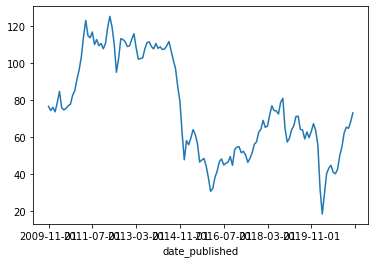

In [33]:
corpus_oil_price_resampled3.Brent.plot()

In [34]:
corpus_oil_price_resampled3['Brent-1'] = corpus_oil_price_resampled3['Brent'].shift(1)
corpus_oil_price_resampled3['vader_sentiment-1'] = corpus_oil_price_resampled3['vader_sentiment'].shift(1)
corpus_oil_price_resampled3

,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,...,month_11.0,month_12.0,Brent,oil_production,oil_consumption,interaction_term,date,interaction_term_2,Brent-1,vader_sentiment-1
date_published,,,,,,,,,,,,,,,,,,,,,
2009-11-01,1.000000,0.998550,11.0,0,0,0,0,0,0,0,...,1,0,76.66,5561,18753,104285433,Nov 09,3.372235,NaN,NaN
2009-12-01,-1.000000,0.098200,12.0,0,0,0,0,0,0,0,...,0,1,74.46,5512,19237,106034344,Dec-09,3.490022,76.66,0.998550
2010-01-01,0.000000,0.128680,1.0,1,0,0,0,0,0,0,...,0,0,76.17,5403,18649,100760547,Jan 10,3.451601,74.46,0.098200
2010-02-01,0.000000,0.567283,2.0,0,1,0,0,0,0,0,...,0,0,73.75,5510,18831,103758810,Feb 10,3.417604,76.17,0.128680
2010-03-01,0.111111,0.848289,3.0,0,0,1,0,0,0,0,...,0,0,78.83,5489,19080,104730120,Mar-10,3.476043,73.75,0.567283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.090909,0.231382,2.0,0,1,0,0,0,0,0,...,0,0,62.28,10000,17444,174440000,Feb 21,1.744400,54.77,-0.210106
2021-03-01,-0.555556,-0.416333,3.0,0,0,1,0,0,0,0,...,0,0,65.41,11100,19204,213164400,Mar-21,1.730090,62.28,0.231382
2021-04-01,0.105263,-0.051500,4.0,0,0,0,1,0,0,0,...,0,0,64.81,10900,19459,212103100,Apr 21,1.785229,65.41,-0.416333


In [35]:
corpus_oil_price_resampled3.drop(index='2009-11-01', columns='baseline_sentiment')

,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,...,month_11.0,month_12.0,Brent,oil_production,oil_consumption,interaction_term,date,interaction_term_2,Brent-1,vader_sentiment-1
date_published,,,,,,,,,,,,,,,,,,,,,
2009-12-01,0.098200,12.0,0,0,0,0,0,0,0,0,...,0,1,74.46,5512,19237,106034344,Dec-09,3.490022,76.66,0.998550
2010-01-01,0.128680,1.0,1,0,0,0,0,0,0,0,...,0,0,76.17,5403,18649,100760547,Jan 10,3.451601,74.46,0.098200
2010-02-01,0.567283,2.0,0,1,0,0,0,0,0,0,...,0,0,73.75,5510,18831,103758810,Feb 10,3.417604,76.17,0.128680
2010-03-01,0.848289,3.0,0,0,1,0,0,0,0,0,...,0,0,78.83,5489,19080,104730120,Mar-10,3.476043,73.75,0.567283
2010-04-01,0.104390,4.0,0,0,0,1,0,0,0,0,...,0,0,84.82,5522,19066,105282452,Apr 10,3.452735,78.83,0.848289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.231382,2.0,0,1,0,0,0,0,0,0,...,0,0,62.28,10000,17444,174440000,Feb 21,1.744400,54.77,-0.210106
2021-03-01,-0.416333,3.0,0,0,1,0,0,0,0,0,...,0,0,65.41,11100,19204,213164400,Mar-21,1.730090,62.28,0.231382
2021-04-01,-0.051500,4.0,0,0,0,1,0,0,0,0,...,0,0,64.81,10900,19459,212103100,Apr 21,1.785229,65.41,-0.416333


### Model 1 

In [36]:
corpus_oil_price_resampled3.dropna(inplace=True)

X = corpus_oil_price_resampled3[['interaction_term_2','vader_sentiment', 
                                ]]
y = corpus_oil_price_resampled3['Brent']

In [37]:
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [38]:
parameters = {'n_estimators': [50, 100], 'max_depth': [2, 10, 50]}
random_forest = RandomForestRegressor(random_state= 42) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)   

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 1/5; 1/6] END max_depth=2, n_estimators=50;, score=-1.151 total time=   0.0s
[CV 2/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 2/5; 1/6] END max_depth=2, n_estimators=50;, score=-15.661 total time=   0.0s
[CV 3/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 3/5; 1/6] END max_depth=2, n_estimators=50;, score=-0.590 total time=   0.0s
[CV 4/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 4/5; 1/6] END max_depth=2, n_estimators=50;, score=-38.304 total time=   0.0s
[CV 5/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 5/5; 1/6] END max_depth=2, n_estimators=50;, score=-1.295 total time=   0.0s
[CV 1/5; 2/6] START max_depth=2, n_estimators=100...............................
[CV 1/5; 2/6] END max_depth=2, n_estimators=100

In [39]:
size = int(0.85 * corpus_oil_price_resampled3.shape[0])
corpus_oil_price_resampled2_2 = corpus_oil_price_resampled3[size:]
corpus_oil_price_resampled2_2['date'] = corpus_oil_price_resampled2_2.index
corpus_oil_price_resampled2_2

<ipython-input-39-045f1cb1da73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_oil_price_resampled2_2['date'] = corpus_oil_price_resampled2_2.index


,baseline_sentiment,vader_sentiment,month,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,...,month_11.0,month_12.0,Brent,oil_production,oil_consumption,interaction_term,date,interaction_term_2,Brent-1,vader_sentiment-1
date_published,,,,,,,,,,,,,,,,,,,,,
2019-10-01,-0.866667,-0.321907,10.0,0,0,0,0,0,0,0,...,0,0,59.71,12600,20714,260996400,2019-10-01,1.643968,62.83,-0.545794
2019-11-01,-0.777778,-0.204144,11.0,0,0,0,0,0,0,0,...,1,0,63.21,12900,20736,267494400,2019-11-01,1.607442,59.71,-0.321907
2019-12-01,0.000000,0.011007,12.0,0,0,0,0,0,0,0,...,0,1,67.31,12900,20443,263714700,2019-12-01,1.584729,63.21,-0.204144
2020-01-01,-0.764706,-0.537024,1.0,1,0,0,0,0,0,0,...,0,0,63.65,12900,19933,257135700,2020-01-01,1.545194,67.31,0.011007
2020-02-01,-0.941176,-0.763759,2.0,0,1,0,0,0,0,0,...,0,0,55.66,13100,20132,263729200,2020-02-01,1.536794,63.65,-0.537024
2020-03-01,-0.777778,-0.435022,3.0,0,0,1,0,0,0,0,...,0,0,32.01,13000,18463,240019000,2020-03-01,1.420231,55.66,-0.763759
2020-04-01,-0.583333,-0.644442,4.0,0,0,0,1,0,0,0,...,0,0,18.38,12100,14549,176042900,2020-04-01,1.202397,32.01,-0.435022
2020-05-01,-0.032258,-0.406752,5.0,0,0,0,0,1,0,0,...,0,0,29.38,11200,16078,180073600,2020-05-01,1.435536,18.38,-0.644442
2020-06-01,-0.166667,-0.485146,6.0,0,0,0,0,0,1,0,...,0,0,40.27,11000,17578,193358000,2020-06-01,1.598000,29.38,-0.406752


In [40]:
y_pred = rf_model.predict(X_test)
corpus_oil_price_resampled2_2['y_pred'] = y_pred


<ipython-input-40-2c6239d564df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_oil_price_resampled2_2['y_pred'] = y_pred


In [26]:
engine = create_engine('sqlite:///oil_1.db')
corpus_oil_price_resampled2_2.to_sql('Table', engine, index=False, if_exists='replace')

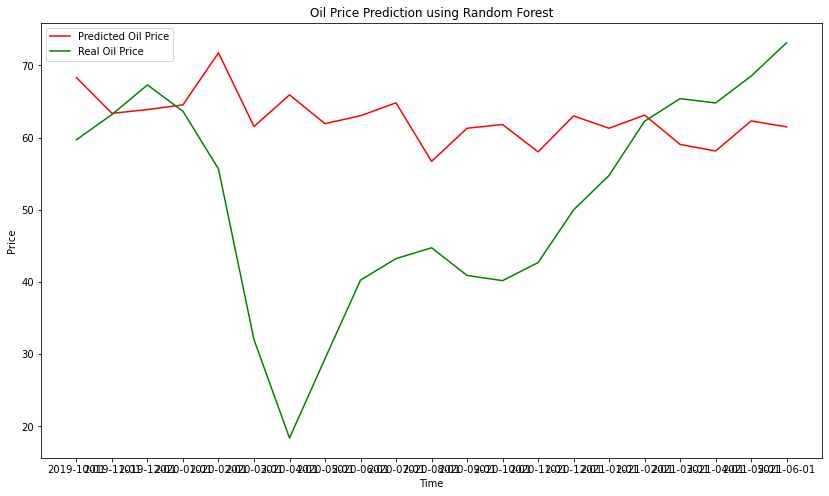

In [41]:
plt.figure(figsize=(14,8))
plt.plot(y_pred, color = 'red', label = 'Predicted Oil Price')
plt.plot(corpus_oil_price_resampled2_2.Brent, color = 'green', label = 'Real Oil Price')
plt.title('Oil Price Prediction using Random Forest')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
# Generate predictions and metrics
training_score = rf_model.score(X_train, y_train)

print(f'The training score is: {round(training_score,3)}')  

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The training score is: 0.935
Mean Absolute Error: 14.467533333333325
Mean Squared Error: 345.66399691619023
Root Mean Squared Error: 18.592041225110012


In [29]:
'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0',
                                'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0',
                                 'month_11.0', 'month_12.0'

IndentationError: unexpected indent (<ipython-input-29-f122ba1c020f>, line 2)

In [43]:
X = corpus_oil_price_resampled3[['interaction_term_2', 'vader_sentiment-1',]]
y = corpus_oil_price_resampled3['Brent']
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
parameters = {'n_estimators': [50, 100], 'max_depth': [2, 10, 50]}
random_forest = RandomForestRegressor(random_state= 42, oob_score=True) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)   
size = int(0.85 * corpus_oil_price_resampled3.shape[0])
corpus_oil_price_resampled2_3 = corpus_oil_price_resampled3[size:]
corpus_oil_price_resampled2_3['date'] = corpus_oil_price_resampled2_3.index
size = int(0.85 * corpus_oil_price_resampled3.shape[0])
corpus_oil_price_resampled2_3 = corpus_oil_price_resampled3[size:]
corpus_oil_price_resampled2_3['date'] = corpus_oil_price_resampled2_3.index
y_pred = rf_model.predict(X_test)
corpus_oil_price_resampled2_3['y_pred'] = y_pred
#engine = create_engine('sqlite:///oil_2.db')
#corpus_oil_price_resampled2_3.to_sql('Table', engine, index=False, if_exists='replace')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 1/5; 1/6] END max_depth=2, n_estimators=50;, score=-1.043 total time=   0.0s
[CV 2/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 2/5; 1/6] END max_depth=2, n_estimators=50;, score=-14.006 total time=   0.0s
[CV 3/5; 1/6] START max_depth=2, n_estimators=50................................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 3/5; 1/6] END max_depth=2, n_estimators=50;, score=-0.754 total time=   0.0s
[CV 4/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 4/5; 1/6] END max_depth=2, n_estimators=50;, score=-38.290 total time=   0.0s
[CV 5/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 5/5; 1/6] END max_depth=2, n_estimators=50;, score=-2.746 total time=   0.0s
[CV 1/5; 2/6] START max_depth=2, n_estimators=100...............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 1/5; 2/6] END max_depth=2, n_estimators=100;, score=-0.982 total time=   0.1s
[CV 2/5; 2/6] START max_depth=2, n_estimators=100...............................
[CV 2/5; 2/6] END max_depth=2, n_estimators=100;, score=-13.847 total time=   0.0s
[CV 3/5; 2/6] START max_depth=2, n_estimators=100...............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 3/5; 2/6] END max_depth=2, n_estimators=100;, score=-0.774 total time=   0.1s
[CV 4/5; 2/6] START max_depth=2, n_estimators=100...............................
[CV 4/5; 2/6] END max_depth=2, n_estimators=100;, score=-38.744 total time=   0.1s
[CV 5/5; 2/6] START max_depth=2, n_estimators=100...............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 5/5; 2/6] END max_depth=2, n_estimators=100;, score=-2.426 total time=   0.1s
[CV 1/5; 3/6] START max_depth=10, n_estimators=50...............................
[CV 1/5; 3/6] END max_depth=10, n_estimators=50;, score=-1.067 total time=   0.0s
[CV 2/5; 3/6] START max_depth=10, n_estimators=50...............................
[CV 2/5; 3/6] END max_depth=10, n_estimators=50;, score=-18.394 total time=   0.0s
[CV 3/5; 3/6] START max_depth=10, n_estimators=50...............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 3/5; 3/6] END max_depth=10, n_estimators=50;, score=-1.140 total time=   0.0s
[CV 4/5; 3/6] START max_depth=10, n_estimators=50...............................
[CV 4/5; 3/6] END max_depth=10, n_estimators=50;, score=-32.267 total time=   0.0s
[CV 5/5; 3/6] START max_depth=10, n_estimators=50...............................
[CV 5/5; 3/6] END max_depth=10, n_estimators=50;, score=-5.457 total time=   0.0s
[CV 1/5; 4/6] START max_depth=10, n_estimators=100..............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 1/5; 4/6] END max_depth=10, n_estimators=100;, score=-1.112 total time=   0.1s
[CV 2/5; 4/6] START max_depth=10, n_estimators=100..............................
[CV 2/5; 4/6] END max_depth=10, n_estimators=100;, score=-17.393 total time=   0.0s
[CV 3/5; 4/6] START max_depth=10, n_estimators=100..............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 3/5; 4/6] END max_depth=10, n_estimators=100;, score=-1.150 total time=   0.1s
[CV 4/5; 4/6] START max_depth=10, n_estimators=100..............................
[CV 4/5; 4/6] END max_depth=10, n_estimators=100;, score=-33.021 total time=   0.0s
[CV 5/5; 4/6] START max_depth=10, n_estimators=100..............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 5/5; 4/6] END max_depth=10, n_estimators=100;, score=-5.217 total time=   0.1s
[CV 1/5; 5/6] START max_depth=50, n_estimators=50...............................
[CV 1/5; 5/6] END max_depth=50, n_estimators=50;, score=-1.157 total time=   0.0s
[CV 2/5; 5/6] START max_depth=50, n_estimators=50...............................
[CV 2/5; 5/6] END max_depth=50, n_estimators=50;, score=-19.183 total time=   0.0s
[CV 3/5; 5/6] START max_depth=50, n_estimators=50...............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 3/5; 5/6] END max_depth=50, n_estimators=50;, score=-1.147 total time=   0.0s
[CV 4/5; 5/6] START max_depth=50, n_estimators=50...............................
[CV 4/5; 5/6] END max_depth=50, n_estimators=50;, score=-32.171 total time=   0.0s
[CV 5/5; 5/6] START max_depth=50, n_estimators=50...............................
[CV 5/5; 5/6] END max_depth=50, n_estimators=50;, score=-5.461 total time=   0.0s
[CV 1/5; 6/6] START max_depth=50, n_estimators=100..............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 1/5; 6/6] END max_depth=50, n_estimators=100;, score=-1.125 total time=   0.1s
[CV 2/5; 6/6] START max_depth=50, n_estimators=100..............................
[CV 2/5; 6/6] END max_depth=50, n_estimators=100;, score=-17.838 total time=   0.0s
[CV 3/5; 6/6] START max_depth=50, n_estimators=100..............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[CV 3/5; 6/6] END max_depth=50, n_estimators=100;, score=-1.154 total time=   0.1s
[CV 4/5; 6/6] START max_depth=50, n_estimators=100..............................
[CV 4/5; 6/6] END max_depth=50, n_estimators=100;, score=-32.891 total time=   0.1s
[CV 5/5; 6/6] START max_depth=50, n_estimators=100..............................


C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kaypa\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-43-b2f20d2fa64a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_oil_price_resampled2_3['date'] = corpus_oil_price_resampled2_3.index
<ipython-input-43-b2f20d2fa64a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

[CV 5/5; 6/6] END max_depth=50, n_estimators=100;, score=-5.220 total time=   0.0s


In [44]:
# Generate predictions and metrics
training_score = rf_model.score(X_train, y_train)
print(f'The training score is: {round(training_score,3)}')  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The training score is: 0.686
Root Mean Squared Error: 19.67327135289212


In [45]:
X = corpus_oil_price_resampled3[['vader_sentiment', 'Brent-1']]
y = corpus_oil_price_resampled3['Brent']
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
parameters = {'n_estimators': [50, 100], 'max_depth': [2, 10, 50]}
random_forest = RandomForestRegressor(random_state= 42) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)   
size = int(0.85 * corpus_oil_price_resampled3.shape[0])
corpus_oil_price_resampled2_4 = corpus_oil_price_resampled3[size:]
corpus_oil_price_resampled2_4['date'] = corpus_oil_price_resampled2_3.index
size = int(0.85 * corpus_oil_price_resampled3.shape[0])
corpus_oil_price_resampled2_4 = corpus_oil_price_resampled3[size:]
corpus_oil_price_resampled2_4['date'] = corpus_oil_price_resampled2_3.index
y_pred = rf_model.predict(X_test)
corpus_oil_price_resampled2_4['y_pred'] = y_pred
engine = create_engine('sqlite:///oil_3.db')
corpus_oil_price_resampled2_4.to_sql('Table', engine, index=False, if_exists='replace')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 1/5; 1/6] END .max_depth=2, n_estimators=50;, score=0.639 total time=   0.0s
[CV 2/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 2/5; 1/6] END .max_depth=2, n_estimators=50;, score=0.034 total time=   0.0s
[CV 3/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 3/5; 1/6] END .max_depth=2, n_estimators=50;, score=0.894 total time=   0.0s
[CV 4/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 4/5; 1/6] END max_depth=2, n_estimators=50;, score=-1.360 total time=   0.0s
[CV 5/5; 1/6] START max_depth=2, n_estimators=50................................
[CV 5/5; 1/6] END max_depth=2, n_estimators=50;, score=-1.614 total time=   0.0s
[CV 1/5; 2/6] START max_depth=2, n_estimators=100...............................
[CV 1/5; 2/6] END max_depth=2, n_estimators=100;,

<ipython-input-45-2e309869b5cf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_oil_price_resampled2_4['date'] = corpus_oil_price_resampled2_3.index
<ipython-input-45-2e309869b5cf>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_oil_price_resampled2_4['date'] = corpus_oil_price_resampled2_3.index
<ipython-input-45-2e309869b5cf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
# Generate predictions and metrics
training_score = rf_model.score(X_train, y_train)
print(f'The training score is: {round(training_score,3)}')  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

### Regression with renewable energies

In [ ]:
corpus_alternative_energies_resampled2

In [ ]:
corpus_alternative_energies_resampled2.isna().sum()

In [ ]:
corpus_alternative_energies_resampled2.index = pd.to_datetime(corpus_alternative_energies_resampled2.index)
corpus_alternative_energies_resampled2['vader_sentiment'].interpolate(method='polynomial', order=2, inplace=True)

In [ ]:
is_NaN = corpus_alternative_energies_resampled2.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = corpus_alternative_energies_resampled2[row_has_NaN]
rows_with_NaN

In [ ]:
corpus_alternative_energies_resampled2.to_csv('data/corpus_alternative_energies_resampled2.csv')
corpus_alternative_energies_resampled2

In [ ]:
corpus_alternative_energies_resampled=pd.read_csv("data/corpus_alternative_energies_resampled2.csv", index_col=0)

In [ ]:
renewables=pd.read_csv("data/renewable_energy_consumption.csv", index_col=0)
renewables.dropna(inplace=True)
renewables

In [ ]:
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled.merge(renewables, on="date_published")
corpus_alternative_energies_resampled2

In [ ]:
corpus_alternative_energies_resampled2['Total_renewable_consumption-1'] = corpus_alternative_energies_resampled2['Total_renewable_consumption'].shift(1)
corpus_alternative_energies_resampled2

In [ ]:
corpus_alternative_energies_resampled2.drop(index='2009-11-01', columns=['baseline_sentiment'])

### Separating data

In [ ]:
corpus_alternative_energies_resampled2.dropna(inplace=True)
X = corpus_alternative_energies_resampled2[['vader_sentiment', 'Industrial_Production_Index', 'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0',
                                'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0',
                                 'month_11.0', 'month_12.0']]
y = corpus_alternative_energies_resampled2['Total_renewable_consumption']

In [ ]:
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [ ]:
parameters = {'n_estimators': [50, 100], 'max_depth': [2, 10, 50]}
random_forest = RandomForestRegressor(random_state= 42) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)

In [ ]:
size = int(0.85 * corpus_alternative_energies_resampled2.shape[0])
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled2[size:]
corpus_alternative_energies_resampled2['date'] = corpus_alternative_energies_resampled2.index
corpus_alternative_energies_resampled2

In [ ]:
y_pred = rf_model.predict(X_test)
corpus_alternative_energies_resampled2['y_pred'] = y_pred

In [ ]:
engine = create_engine('sqlite:///energy.db')
corpus_alternative_energies_resampled2.to_sql('Table', engine, index=False, if_exists='replace')

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(y_pred, color = 'red', label = 'Predicted Renewable Energy Consumption')
plt.plot(corpus_alternative_energies_resampled2['Total_renewable_consumption'], color = 'green', label = 'Observed Renewable Energy Consumption')
plt.title('Renewable Energy Demand Prediction using Random Forest')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [ ]:
# Generate predictions and metrics
training_score = rf_model.score(X_train, y_train)
print(f'The training score is: {round(training_score,3)}')  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
corpus_alternative_energies_resampled=pd.read_csv("data/corpus_alternative_energies_resampled2.csv", index_col=0)
renewables=pd.read_csv("data/renewable_energy_consumption.csv", index_col=0)
renewables.dropna(inplace=True)
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled.merge(renewables, on="date_published")
corpus_alternative_energies_resampled2['Total_renewable_consumption-1'] = corpus_alternative_energies_resampled2['Total_renewable_consumption'].shift(1)
corpus_alternative_energies_resampled2['vader_sentiment-1'] = corpus_alternative_energies_resampled2['vader_sentiment'].shift(1)
corpus_alternative_energies_resampled2.drop(index='2009-11-01', columns=['baseline_sentiment'])
corpus_alternative_energies_resampled2['date'] = corpus_alternative_energies_resampled2.index

In [ ]:
corpus_alternative_energies_resampled2.dropna(inplace=True)
X = corpus_alternative_energies_resampled2[['vader_sentiment', 'Industrial_Production_Index', 'vader_sentiment-1',
                                         'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0',
                                'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0',
                                 'month_11.0', 'month_12.0'  
                                           
                                           ]]
y = corpus_alternative_energies_resampled2['Total_renewable_consumption']
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
parameters = {'n_estimators': [50, 100], 'max_depth': [2, 10, 50]}
random_forest = RandomForestRegressor(random_state= 42) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)
size = int(0.85 * corpus_alternative_energies_resampled2.shape[0])
corpus_alternative_energies_resampled3 = corpus_alternative_energies_resampled2[size:]
y_pred = rf_model.predict(X_test)
corpus_alternative_energies_resampled3['y_pred'] = y_pred
engine = create_engine('sqlite:///energy2.db')
corpus_alternative_energies_resampled3.to_sql('Table', engine, index=False, if_exists='replace')

In [ ]:
# Generate predictions and metrics
training_score = rf_model.score(X_train, y_train)
print(f'The training score is: {round(training_score,3)}')  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
corpus_alternative_energies_resampled=pd.read_csv("data/corpus_alternative_energies_resampled2.csv", index_col=0)
renewables=pd.read_csv("data/renewable_energy_consumption.csv", index_col=0)
renewables.dropna(inplace=True)
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled.merge(renewables, on="date_published")
corpus_alternative_energies_resampled2['Total_renewable_consumption-1'] = corpus_alternative_energies_resampled2['Total_renewable_consumption'].shift(1)
corpus_alternative_energies_resampled2['vader_sentiment-1'] = corpus_alternative_energies_resampled2['vader_sentiment'].shift(1)
corpus_alternative_energies_resampled2.drop(index='2009-11-01', columns=['baseline_sentiment'])
corpus_alternative_energies_resampled2['date'] = corpus_alternative_energies_resampled2.index

In [ ]:
corpus_alternative_energies_resampled2.dropna(inplace=True)
X = corpus_alternative_energies_resampled2[['vader_sentiment', 'Industrial_Production_Index', 'Total_renewable_consumption-1',
                                           'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0',
                                'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0',
                                 'month_11.0', 'month_12.0'
                                           
                                           
                                           ]]
y = corpus_alternative_energies_resampled2['Total_renewable_consumption']
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
parameters = {'n_estimators': [50, 100], 'max_depth': [2, 10, 50]}
random_forest = RandomForestRegressor(random_state= 42) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)
size = int(0.85 * corpus_alternative_energies_resampled2.shape[0])
corpus_alternative_energies_resampled3 = corpus_alternative_energies_resampled2[size:]
y_pred = rf_model.predict(X_test)
corpus_alternative_energies_resampled3['y_pred'] = y_pred
engine = create_engine('sqlite:///energy3.db')
corpus_alternative_energies_resampled3.to_sql('Table', engine, index=False, if_exists='replace')

In [ ]:
# Generate predictions and metrics
training_score = rf_model.score(X_train, y_train)
print(f'The training score is: {round(training_score,3)}')  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))